In [ ]:
"""
CS6440 - Intro to Health Informatics
Mini Project #4 - Predictive Analytics
David Strube - dstrube3@gatech.edu
"""

#######################################################################
#1 Verify imports
#######################################################################
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import numpy as np

from sklearn import preprocessing
from sklearn import tree
#from sklearn.datasets import fetch_openml
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

import time

#allow plots to appear within the notebook:
%matplotlib inline

print("All imports are good")

All imports are good


In [ ]:
#######################################################################
#2 Get the data
#######################################################################
dataset1 = load_breast_cancer()
#Alternative data sources:
#a:
#https://chronicdata.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Behavioral/hn4x-zwk7
#b:
#https://chronicdata.cdc.gov/Survey-Data/Behavioral-Risk-Factor-Data-Tobacco-Use-2011-to-pr/wsas-xwh5
#c:
#https://www.openml.org/d/1000
#dataset1 = fetch_openml(name='hypothyroid', version=1) 
#d:
#https://www.openml.org/d/42738
#dataset1 = fetch_openml(name='open_payments', version='active') 

#######################################################################
#2.1 Clean the data
#######################################################################
dataset1.data = preprocessing.normalize(dataset1.data)
#Alternatively scale:
#dataset1.data = preprocessing.scale(dataset1.data)
dataset1.target = preprocessing.LabelEncoder().fit_transform(dataset1.target)
#Per data description, there are no missing values

#######################################################################
#2.2 Initialize data related variables
#######################################################################
X_ds1 = dataset1.data #matrix
y_ds1 = dataset1.target #vector
#Split training data from testing data
X_Train_ds1, X_Test_ds1, y_Train_ds1, y_Test_ds1 = \
    train_test_split(X_ds1, y_ds1, test_size=0.2, random_state=0) 

#######################################################################
#2.3 Initialize other global variables:
#######################################################################
cv_ds1 = 0
criterion_ds1 = ''

#Minimum score to give scale for plot_learning_curve
min_score = 0

#Classifier returned from decisionTree functions, consumed by confusionMatrix
clf = None

#Two variables here in case we want to use some other data gathering method 
#(like fetch_openml) which requires a string input which might be different from
#the labelling we want to print on info and debug statements
dataset_name = 'breast_cancer'
current_dataset = "Dataset (" + dataset_name + ")"

print("Data gotten, and other global variables initialized")


Data gotten, and other global variables initialized


In [ ]:
#######################################################################
#3 Functions
#######################################################################

def decisionTree(X_Train, y_Train, cv_max=100):
    cross_val_sizes = range(2,(cv_max+1))
    criteria = ['gini','entropy']
    best_score = 0
    min_score = 1.0
    cv_ds = 0
    criterion_ds = ''
    
    print("Exploring Decision Trees with no pruning...")
    start = time.time()
    for criterion in criteria:
    
        scores = []
        for i in cross_val_sizes:
            dtc = tree.DecisionTreeClassifier(random_state=0, criterion=criterion)
            score = cross_val_score(dtc, X_Train, y_Train, cv=i).mean()
            scores.append(score)
            if score > best_score:
                best_score = score
                cv_ds = i
                criterion_ds=criterion
                print("cv=" + str(i) + ", criterion="+criterion+" : " + str(score))
            if score < min_score:
                min_score = score

        plt.plot(cross_val_sizes, scores, label=criterion)
        plt.xlabel("Cross validation size")
        plt.ylabel("Cross validation score (Performance)")
    
    plt.legend() 
    plt.show()   

    end = time.time()
    
    print("Decision Trees " + current_dataset + " best score = " + str(best_score) + " at cv = " \
          + str(cv_ds) + "(criterion="+criterion_ds+") in "+ getTime(end - start))
    
    dtc = tree.DecisionTreeClassifier(random_state=0, criterion=criterion_ds)
    return cv_ds, criterion_ds, min_score, dtc

def decisionTreePrePruning(X_Train, y_Train, cv_ds, criterion_ds):
    max_depth_sizes = range(2,21)
    scores = []
    best_score = 0
    min_score = 1.0
    max_depth_ds = 0
    
    start = time.time()
    
    print("Exploring Decision Trees with pre-pruning...")
    for md in max_depth_sizes:
        dtc = tree.DecisionTreeClassifier(random_state=0, max_depth=md)
        score = cross_val_score(dtc, X_Train, y_Train, cv=cv_ds).mean()
        scores.append(score)
        if score > best_score:
            best_score = score
            max_depth_ds = md
            print("Max depth size:" + str(md) + " : " + str(score))
        if score < min_score:
            min_score = score
            
    end = time.time()
    
    print("Decision Trees " + current_dataset + " with pre-pruning best score = " \
        + str(best_score) + " at max_depth = " + str(max_depth_ds) + " in "+ getTime(end - start))
    plt.plot(max_depth_sizes, scores)
    plt.xlabel("Max depth size")
    plt.ylabel("Score")
    
    dtc = tree.DecisionTreeClassifier(random_state=0, max_depth=max_depth_ds)
    
    return min_score, dtc

def decisionTreePostPruning(X_Train, y_Train, cv_ds, criterion_ds):
    ccp_alpha_sizes = range(0,11)
    scores = []
    best_score = 0
    min_score = 1.0
    ccp_alpha_ds = 0

    start = time.time()
    
    print("Exploring Decision Trees with post-pruning...")
    for ccpa in ccp_alpha_sizes:
        dtc = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccpa)
        score = cross_val_score(dtc, X_Train, y_Train, cv=cv_ds).mean()
        scores.append(score)
        if score > best_score:
            best_score = score
            ccp_alpha_ds = ccpa
            print(str(ccpa) + " : " + str(score))
        if score < min_score:
            min_score = score
    
    end = time.time()
    
    print("Decision Trees " + current_dataset + " with post-pruning best score = " \
        + str(best_score) + " at ccp_alpha = " + str(ccp_alpha_ds) + " in "+ getTime(end - start))
    plt.plot(ccp_alpha_sizes, scores)
    plt.xlabel("CCP alpha size")
    plt.ylabel("Score")
    
    dtc = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha_ds)
    
    return min_score, dtc

def confusionMatrix(X_Train, X_Test, y_Train, y_Test, clf, normalize, is_debug=False):
    clf.fit(X_Train, y_Train)
    plot_confusion_matrix(clf, X_Test, y_Test, normalize=normalize, cmap=plt.cm.Blues)  
    plt.show() 
    
def plot_learning_curve(estimator, X, y, cv_n_splits, min_score):
    
    train_sizes=np.linspace(.1, 1.0, 5)
    ylim=((min_score - 0.1), 1.01)
    _, axes = plt.subplots(3, 1, figsize=(10, 15))
    axes[0].set_title("Learning Curves")

    axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    cv = ShuffleSplit(n_splits=cv_n_splits, test_size=0.2, random_state=0)
    n_jobs=-1
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    plt.show()
    
def getTime(seconds):
    if int(seconds / 60) == 0:
        return str(int(seconds)) + " second(s)"
    minutes = int(seconds / 60)
    seconds = int(seconds % 60)
    if int(minutes / 60) == 0:
        return str(minutes) + " minute(s) and " + str(seconds) + " second(s)"
    hours = int(minutes / 60)
    minutes = int(minutes % 60)
    return str(hours) + " hour(s), " + str(minutes) + " minute(s), and " + str(seconds) + " second(s)"

print("Functions have been defined")

Functions have been defined


In [ ]:
#######################################################################
#4 Explore Dataset 1
#######################################################################
print(current_dataset + " target names:")
print(dataset1.target_names) 
print(current_dataset + " targets:")
print(np.unique(dataset1.target))
print(current_dataset + " data shape:")
print(X_ds1.shape) 
print("rows: " + str(X_ds1.shape[0]) + "; columns: " + str(X_ds1.shape[1]))
print(current_dataset + " description:")
print(dataset1.DESCR) 



Dataset (breast_cancer) target names:
['malignant' 'benign']
Dataset (breast_cancer) targets:
[0 1]
Dataset (breast_cancer) data shape:
(569, 30)
rows: 569; columns: 30
Dataset (breast_cancer) description:
.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean

Exploring Decision Trees with no pruning...
cv=2, criterion=gini : 0.9340462941494706
cv=4, criterion=gini : 0.9406730321378668
cv=6, criterion=gini : 0.947251461988304
cv=9, criterion=gini : 0.9582135076252725
cv=35, criterion=gini : 0.9582417582417583
cv=93, criterion=gini : 0.9591397849462364


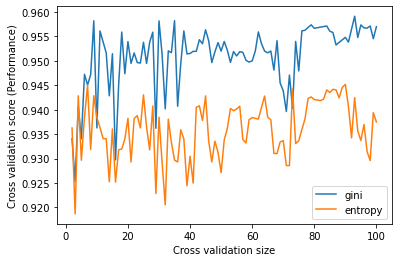

Decision Trees Dataset (breast_cancer) best score = 0.9591397849462364 at cv = 93(criterion=gini) in 1 minute(s) and 31 second(s)


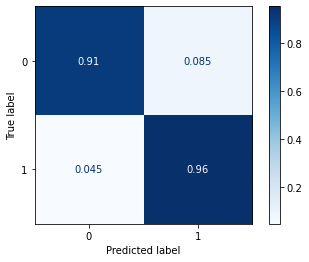

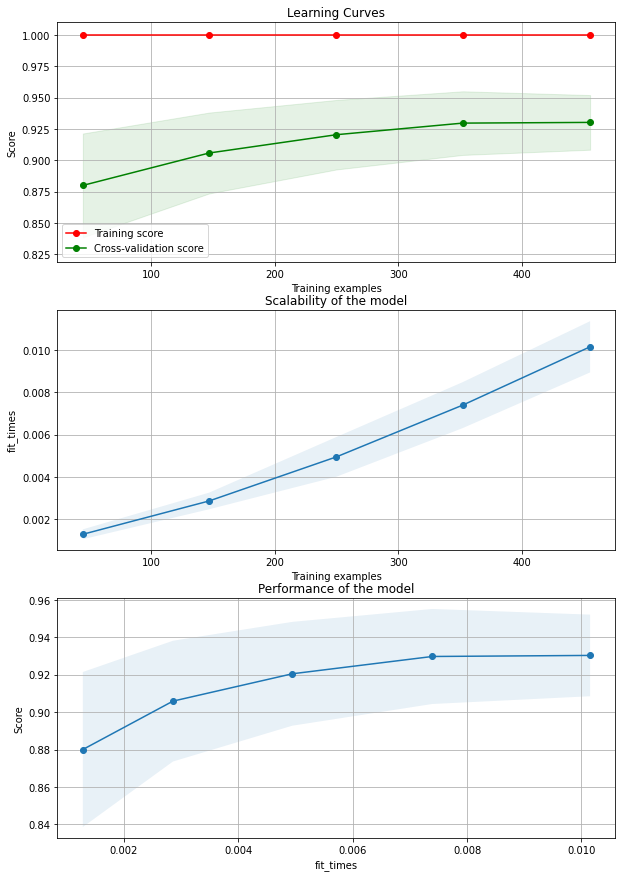

In [ ]:
#######################################################################
#4.1 Decision Trees
#######################################################################
cv_ds1, criterion_ds1, min_score, clf = decisionTree(X_Train_ds1, y_Train_ds1)

confusionMatrix(X_Train_ds1, X_Test_ds1, y_Train_ds1, y_Test_ds1, clf, 'true')
plot_learning_curve(clf, X_ds1, y_ds1, cv_ds1, min_score)

Exploring Decision Trees with pre-pruning...
Max depth size:2 : 0.9048387096774194
Max depth size:3 : 0.9435483870967742
Max depth size:4 : 0.9543010752688172
Max depth size:5 : 0.9655913978494625
Decision Trees Dataset (breast_cancer) with pre-pruning best score = 0.9655913978494625 at max_depth = 5 in 13 second(s)


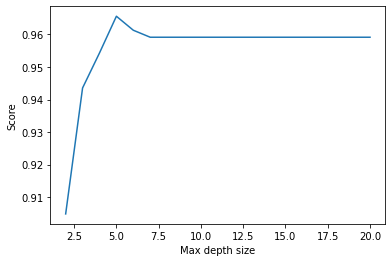

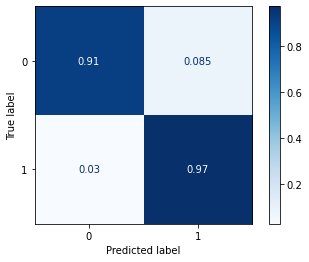

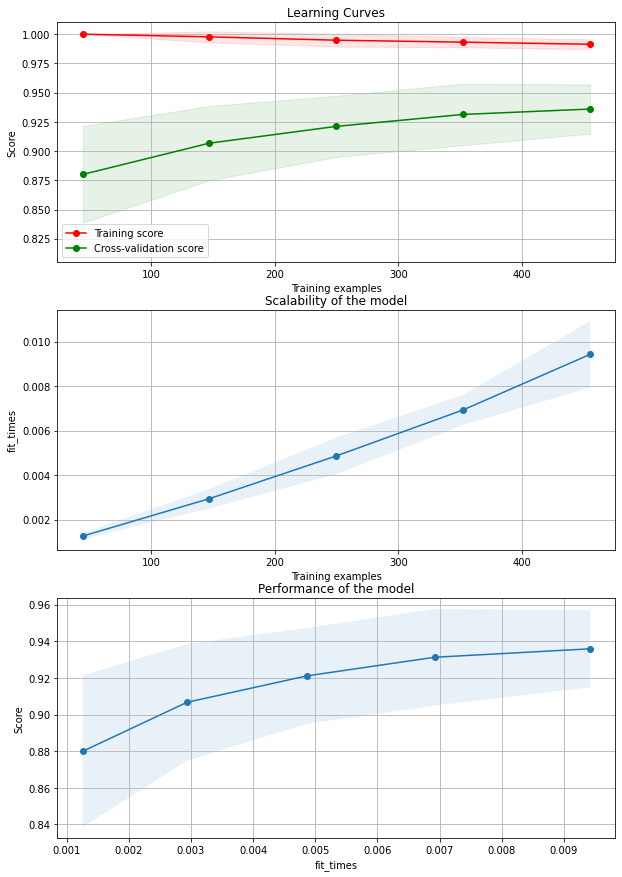

In [ ]:
#######################################################################
#4.1.1 Decision Tree with pre-pruning
#######################################################################
min_score, clf = decisionTreePrePruning(X_Train_ds1, y_Train_ds1, cv_ds1, criterion_ds1)
confusionMatrix(X_Train_ds1, X_Test_ds1, y_Train_ds1, y_Test_ds1, clf, 'true')
plot_learning_curve(clf, X_ds1, y_ds1, cv_ds1, min_score)

Exploring Decision Trees with post-pruning...
0 : 0.9591397849462364
Decision Trees Dataset (breast_cancer) with post-pruning best score = 0.9591397849462364 at ccp_alpha = 0 in 8 second(s)


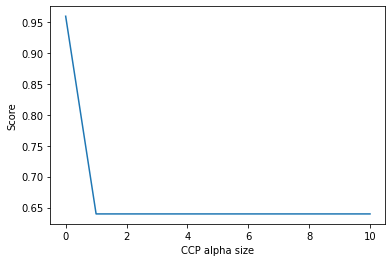

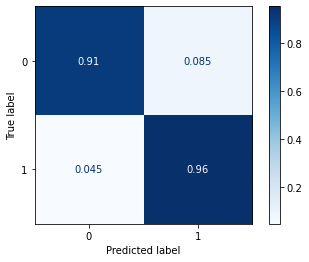

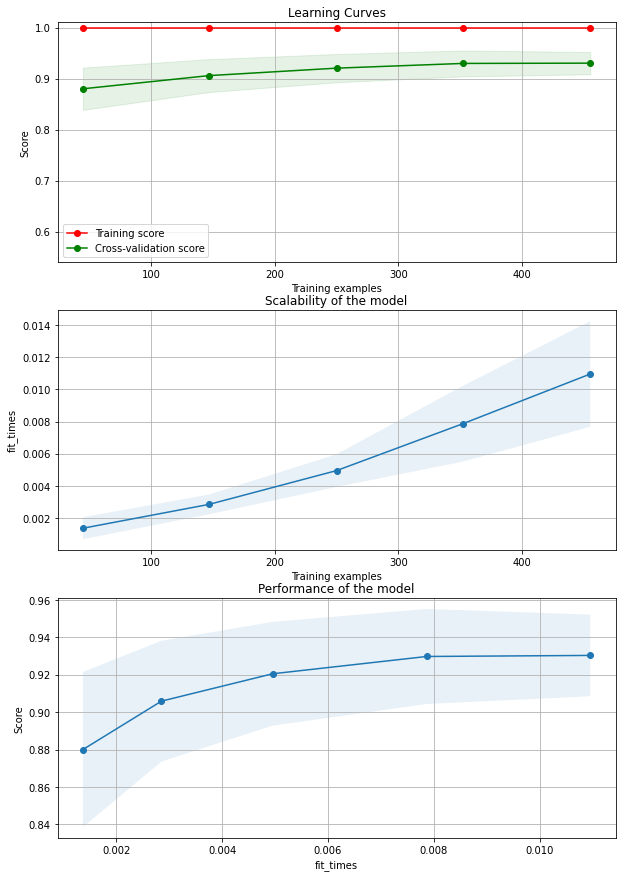

In [ ]:
#######################################################################
#4.1.2 Decision Tree with post-pruning
#######################################################################
min_score, clf = decisionTreePostPruning(X_Train_ds1, y_Train_ds1, cv_ds1, criterion_ds1)
confusionMatrix(X_Train_ds1, X_Test_ds1, y_Train_ds1, y_Test_ds1, clf, 'true')
plot_learning_curve(clf, X_ds1, y_ds1, cv_ds1, min_score)